# Street merging and plotting

## Imports

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
import shapely.wkt
from shapely.geometry import Point
from importnb import Notebook
with Notebook():
    from Preprocessing import replace_chars_by_dict, preprocess, map_dict


In [3]:
voies = gpd.read_file("data/voie.zip", encoding='utf-8')
old = gpd.read_file("data/1791.zip", encoding='utf-8')

## Dataset manipulations

In [4]:
# open Paris data
# add year
voies["year"] = 2022
# change to EPSG
voies = voies.to_crs(epsg=3857)
# add centroid
voies["centroid"] = voies.centroid

# old Paris data
# change "None" to "" and create long street name
old.iloc[:,1:4] = old.iloc[:,1:4].fillna(value="")
old["l_longmin"] = old["type_voie"] + " " + old["particule"] + " " + old["nom_voie"]
# delete empty lines
mask = old["l_longmin"] != "  "
old = old[mask]
# add year
old["year"] = "1791"
# change to EPSG
old = old.to_crs(epsg=3857)
# add centroid
old["centroid"] = old.centroid

,id,type_voie,particule,nom_voie,geometry,l_longmin,year,centroid
0,1162,rue,des,deux Boules,"LINESTRING (261047.657 6251000.288, 261087.913...",rue des deux Boules,1791,POINT (261108.718 6250962.986)
1,1531,rue,,Jean Lantier,"LINESTRING (261036.345 6250951.797, 261095.921...",rue Jean Lantier,1791,POINT (261095.261 6250923.156)
2,3,rue,des,Orfèvres,"LINESTRING (261058.491 6250823.239, 261095.921...",rue des Orfèvres,1791,POINT (261077.206 6250873.037)
3,4,rue,des,mauvaises Paroles,"LINESTRING (261046.018 6251085.086, 261137.796...",rue des mauvaises Paroles,1791,POINT (261129.428 6251035.211)
4,5,rue,du,Plat d'Etain,"LINESTRING (261166.004 6251079.270, 261203.293...",rue du Plat d'Etain,1791,POINT (261201.172 6251046.433)
...,...,...,...,...,...,...,...,...
1519,1514,quay,de la,Rapée,"LINESTRING (263495.393 6248758.551, 263644.526...",quay de la Rapée,1791,POINT (264233.784 6247918.108)
1520,1527,quay,de,Bercy,"LINESTRING (264907.034 6247021.082, 264974.916...",quay de Bercy,1791,POINT (265623.836 6246215.960)
1521,1528,quay,des,Galleries du Louvre,"LINESTRING (260061.338 6251037.306, 259778.305...",quay des Galleries du Louvre,1791,POINT (259740.865 6251137.881)
1522,1525,quay,des,Thuileries,"LINESTRING (259419.213 6251234.635, 258831.636...",quay des Thuileries,1791,POINT (258851.611 6251522.206)


## Find same streets

In [52]:
# Preprocessing, (! from now on use l_longmin_prep)
old_preprocessed = preprocess(old, "l_longmin", map_dict)
voies_preprocessed = preprocess(voies, "l_longmin", map_dict)


In [ ]:
# Finding matching street names in old and voies
# defining function
def in_list(x, list):
    return x in list
# list of all streetnames
old_mask = list(old_preprocessed["l_longmin_prep"])
voies_mask = list(voies_preprocessed["l_longmin_prep"])

# making dataframes
old_preprocessed["match"] = old_preprocessed["l_longmin_prep"].apply(lambda x: in_list(x, voies_mask))
voies_preprocessed["match"] = voies_preprocessed["l_longmin_prep"].apply(lambda x: in_list(x, old_mask))


In [56]:
np.isin(old_preprocessed["l_longmin_prep"], voies_preprocessed["l_longmin_prep"])

array([ True, False,  True, ..., False, False, False])

In [50]:
# List of all duplicates in 1791 data
# All duplicates in the 1791 data
old_streets = pd.DataFrame(old_mask)
mask = old_streets.duplicated()
dup_all = old_streets[mask].iloc[:,0].unique()
# All duplicates there in the 1791 and 2022 data
dup_match = old_dup['l_longmin_prep'].unique()

# List of duplicates only in 1971 data
mask = np.isin(dup_all, dup_match)
#dup_old = dup_all[mask]
dup_old = dup_all[~mask]

# df of streets only in 1791 dataset (not in 2022)


array(['rue des deux portes', 'rue de la poterie', 'rue  oblin',
       'rue des vieilles etuves', 'rue  fermee', "rue d' orleans",
       'rue  pavee', "rue de l' echaude", 'rue  saint claude',
       'cul de sac  saint pierre', 'rue  saint louis',
       'rue de la lanterne', 'rue  percee', 'rue des lavandieres',
       'rue des pretres', "rue d' anjou", 'rue du paon', 'rue  clopin',
       'rue  contrescarpe', 'rue  francaise', 'rue de touraine',
       'rue du petit lion', "rue d' enfer", "rue de l' egout",
       'rue du pont aux biches', 'rue des deux anges', "quay d' orsay",
       "rue de l' etoile", 'rue  saint dominique', 'rue du petit bourbon',
       'rue du coq', 'quay de bourbon', 'cul de sac  saint claude',
       'petite rue  saint pierre', 'rue  saint honore',
       'rue des boucheries', 'rue  royale', "rue  neuve d'orleans",
       'boulevard  saint martin', 'rue  traversiere',
       'rue  saint nicolas', 'rue des charbonniers',
       'rue  sainte marguerite', 'rue

In [6]:
# Temporär
sum(voies_preprocessed["match"])
sum(old_preprocessed["match"])

a = voies_preprocessed["l_longmin_prep"].to_dict()
len(a) - len(voies_preprocessed)

0

In [7]:
# DF with streets with shared name
voies_match = voies_preprocessed[voies_preprocessed["match"]]
old_match = old_preprocessed[old_preprocessed["match"]]

## Merge DF



In [8]:
tst = old_match["l_longmin_prep"].to_dict()
len(tst)
len(voies_match)

204

In [9]:
len({value:key for key, value in tst.items()})

204

## Assessing duplicates in 1791 data

In [10]:
mask = old_match["l_longmin_prep"].duplicated()
old_dup = old_match[mask]
duplicates = list(old_dup["l_longmin_prep"])

mask = old_match["l_longmin_prep"].apply(lambda x: in_list(x, duplicates))
old_dup = old_match[mask]

In [11]:
mask = old_dup["l_longmin_prep"] == "rue du four"
four = old_dup[mask]
len(voies)

6542

In [20]:
voies
old_match

,id,type_voie,particule,nom_voie,geometry,l_longmin,year,centroid,l_longmin_prep,match
0,1162,rue,des,deux Boules,"LINESTRING (261047.657 6251000.288, 261087.913...",rue des deux Boules,1791,POINT (261108.718 6250962.986),rue des deux boules,True
2,3,rue,des,Orfèvres,"LINESTRING (261058.491 6250823.239, 261095.921...",rue des Orfèvres,1791,POINT (261077.206 6250873.037),rue des orfevres,True
4,5,rue,du,Plat d'Etain,"LINESTRING (261166.004 6251079.270, 261203.293...",rue du Plat d'Etain,1791,POINT (261201.172 6251046.433),rue du plat d'etain,True
6,7,rue,des,Déchargeurs,"LINESTRING (261137.796 6251034.398, 261166.004...",rue des Déchargeurs,1791,POINT (261186.691 6251108.913),rue des dechargeurs,True
33,33,rue,de la,Ferronnerie,"LINESTRING (261198.825 6251200.575, 261233.772...",rue de la Ferronnerie,1791,POINT (261303.189 6251172.915),rue de la ferronnerie,True
...,...,...,...,...,...,...,...,...,...,...
1404,1362,rue,de,Valois,"LINESTRING (256892.899 6253852.965, 257132.864...",rue de Valois,1791,POINT (257403.144 6254237.322),rue de valois,True
1405,1363,rue,de,Chartres,"LINESTRING (256373.376 6254334.641, 256402.624...",rue de Chartres,1791,POINT (256641.636 6254101.865),rue de chartres,True
1406,1360,rue,de,Courcelles,"LINESTRING (256892.899 6253852.965, 256984.464...",rue de Courcelles,1791,POINT (257087.274 6253576.833),rue de courcelles,True
1436,1392,rue,des,Vignes,"LINESTRING (256020.591 6253015.605, 256242.619...",rue des Vignes,1791,POINT (256131.605 6252944.899),rue des vignes,True


In [18]:
# Going through 23 Streets by hand to see what kind of duplicate it is
# confirmed the first streets (rue des mauvais garcons, rue du renard, rue du platre)
# with Alpage, 1790 dataset

mask = old_dup["l_longmin_prep"] == "rue du platre"
dup = old_dup[mask]
dup.explore()

## Plotting

In [7]:
centroid_voies_match = gpd.GeoDataFrame(voies_match, geometry = "centroid")
centroid_old_match = gpd.GeoDataFrame(old_match, geometry = "centroid")

In [8]:
centroid_old_match.explore()

In [9]:
centroid_voies_match.explore()

In [72]:
voies_match.explore()

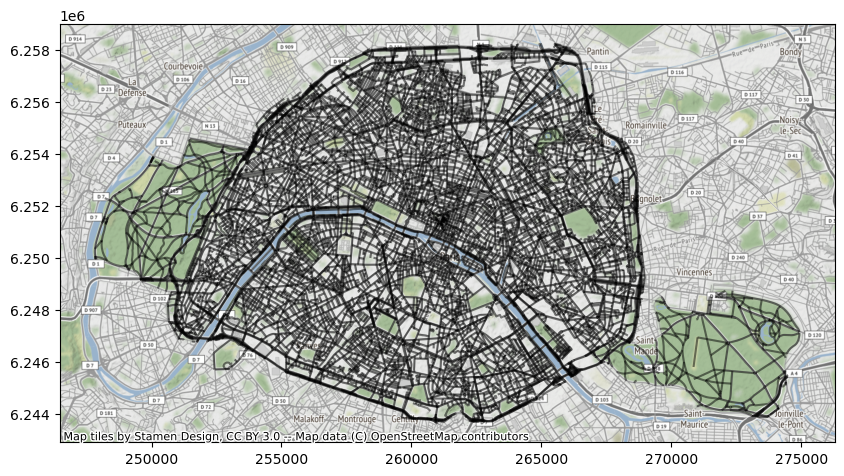

In [ ]:
# Producing the plot
ax = voies.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
cx.add_basemap(ax)

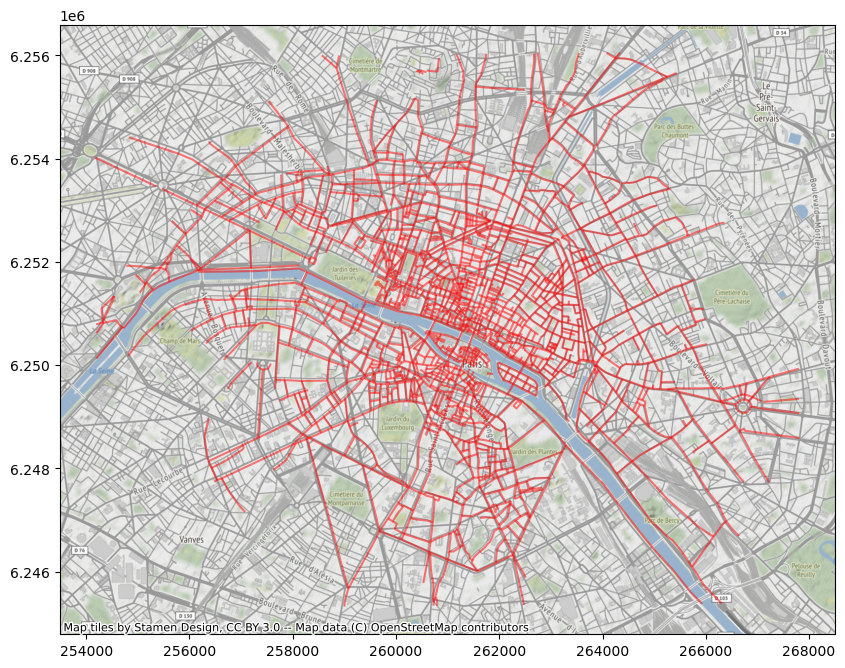

In [ ]:
# Producing the plot
ax = old.plot(figsize=(10, 10), alpha=0.5, edgecolor='r')
cx.add_basemap(ax)